# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import warnings 
warnings.filterwarnings("ignore")

# Load the Data

In [2]:
df = pd.read_csv("Crop Production data.csv")

In [3]:
df.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,ANDAMAN AND NICOBAR,NICOBAR ISLANDS,2000,Kharif,Arecanut,1254.0,2000.0
1,ANDAMAN AND NICOBAR,NICOBAR ISLANDS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,ANDAMAN AND NICOBAR,NICOBAR ISLANDS,2000,Kharif,Rice,102.0,321.0
3,ANDAMAN AND NICOBAR,NICOBAR ISLANDS,2000,Whole Year,Banana,176.0,641.0
4,ANDAMAN AND NICOBAR,NICOBAR ISLANDS,2000,Whole Year,Cashewnut,720.0,165.0


## Checking the data

In [4]:
print("Number of coluns : ", df.shape[1])
print("Number of Rows : ", df.shape[0])

Number of coluns :  7
Number of Rows :  246091


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   District_Name  246091 non-null  object 
 2   Crop_Year      246091 non-null  int64  
 3   Season         246091 non-null  object 
 4   Crop           246091 non-null  object 
 5   Area           246091 non-null  float64
 6   Production     242361 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.1+ MB


In [6]:
df.describe()

,Crop_Year,Area,Production
count,246091.000000,2.460910e+05,2.423610e+05
mean,2005.643018,1.200282e+04,5.825034e+05
std,4.952164,5.052340e+04,1.706581e+07
min,1997.000000,4.000000e-02,0.000000e+00
25%,2002.000000,8.000000e+01,8.800000e+01
50%,2006.000000,5.820000e+02,7.290000e+02
75%,2010.000000,4.392000e+03,7.023000e+03
max,2015.000000,8.580100e+06,1.250800e+09


### Finding Null Values

In [7]:
df.isnull().sum()

State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Production       3730
dtype: int64

### Finding Duplicated Values

In [8]:
print("Number of Duplicated value : ", df.duplicated().sum())

Number of Duplicated value :  0


# Exploratory Data Analysis (EDA)

In [9]:
des = df.describe().transpose()
des.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Crop_Year,246091.000000,2005.643018,4.952164,1997.000000,2002.000000,2006.000000,2010.000000,2015.000000
Area,246091.000000,12002.820864,50523.404019,0.040000,80.000000,582.000000,4392.000000,8580100.000000
Production,242361.000000,582503.442251,17065813.172410,0.000000,88.000000,729.000000,7023.000000,1250800000.000000


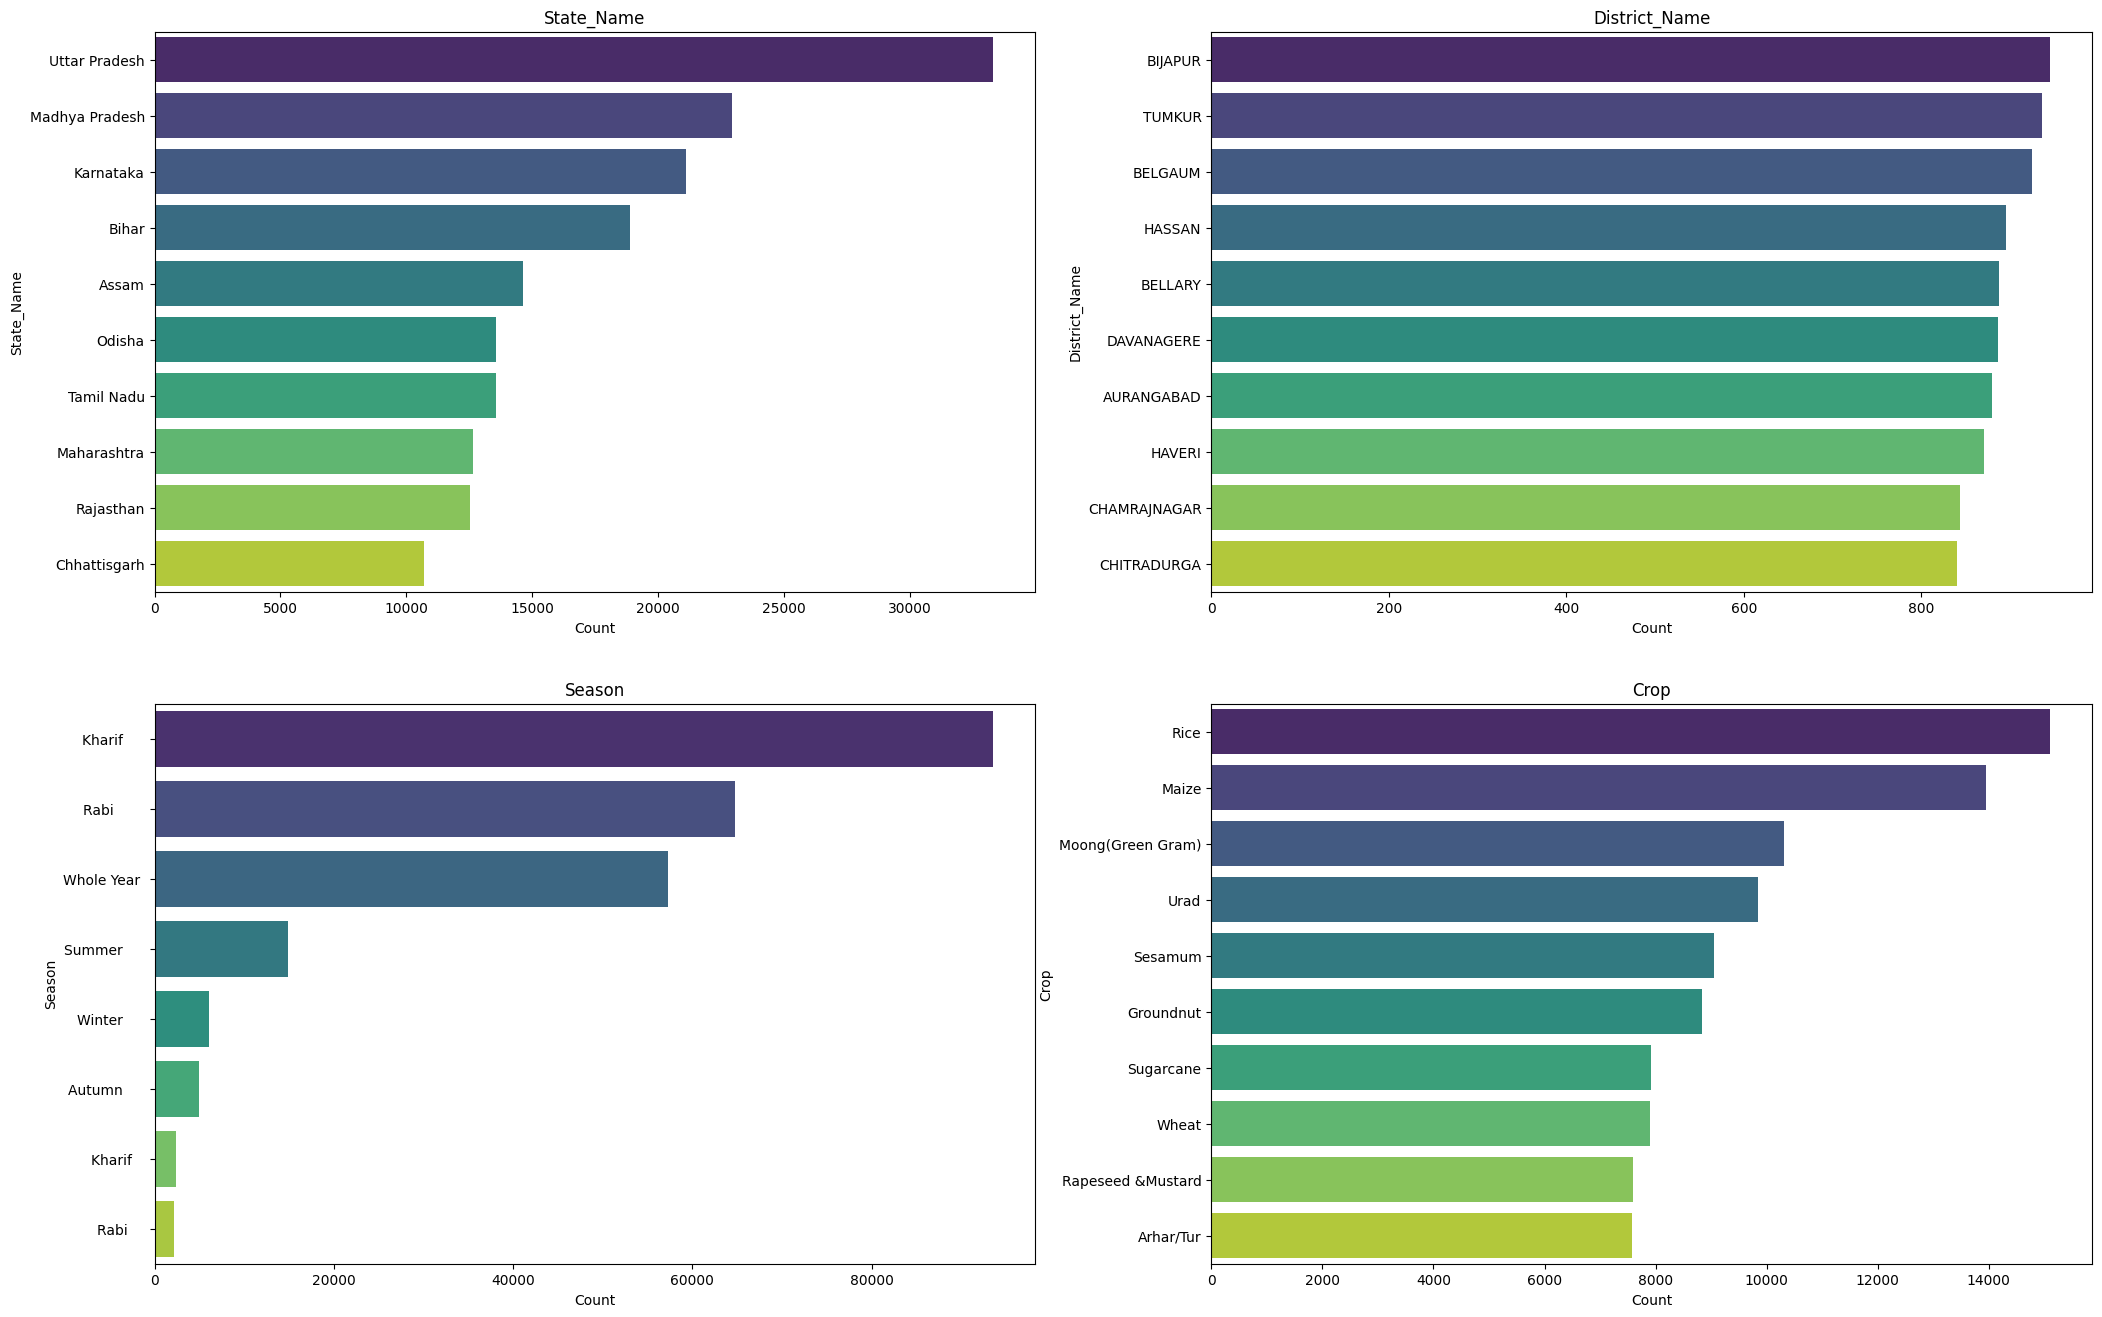

In [10]:
plt.figure(figsize=(25, 16))
for i, feature in enumerate(df.select_dtypes(include="object").columns):
    counts = df[feature].value_counts().head(10)
    plt.subplot(2, 2, i+1)
    sns.barplot(x=counts.values, y=counts.index, palette='viridis')
    plt.title(f"{feature}")
    plt.ylabel(f"{feature}")
    plt.xlabel("Count")
plt.show()

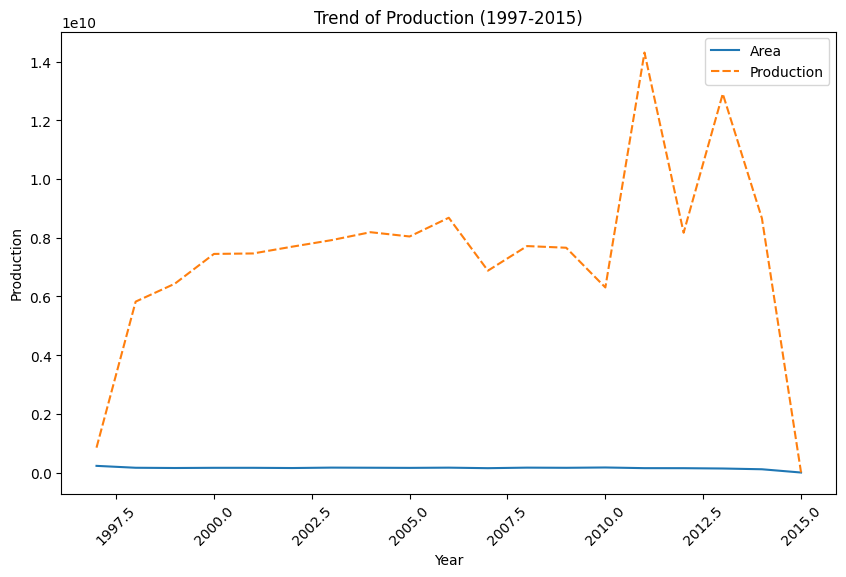

In [11]:
group_by_year = df.groupby("Crop_Year").sum()

plt.figure(figsize=(10,6))
sns.lineplot(data=group_by_year)
plt.title("Trend of Production (1997-2015)")
plt.xlabel("Year")
plt.ylabel("Production")
plt.xticks(rotation=45)
plt.show()

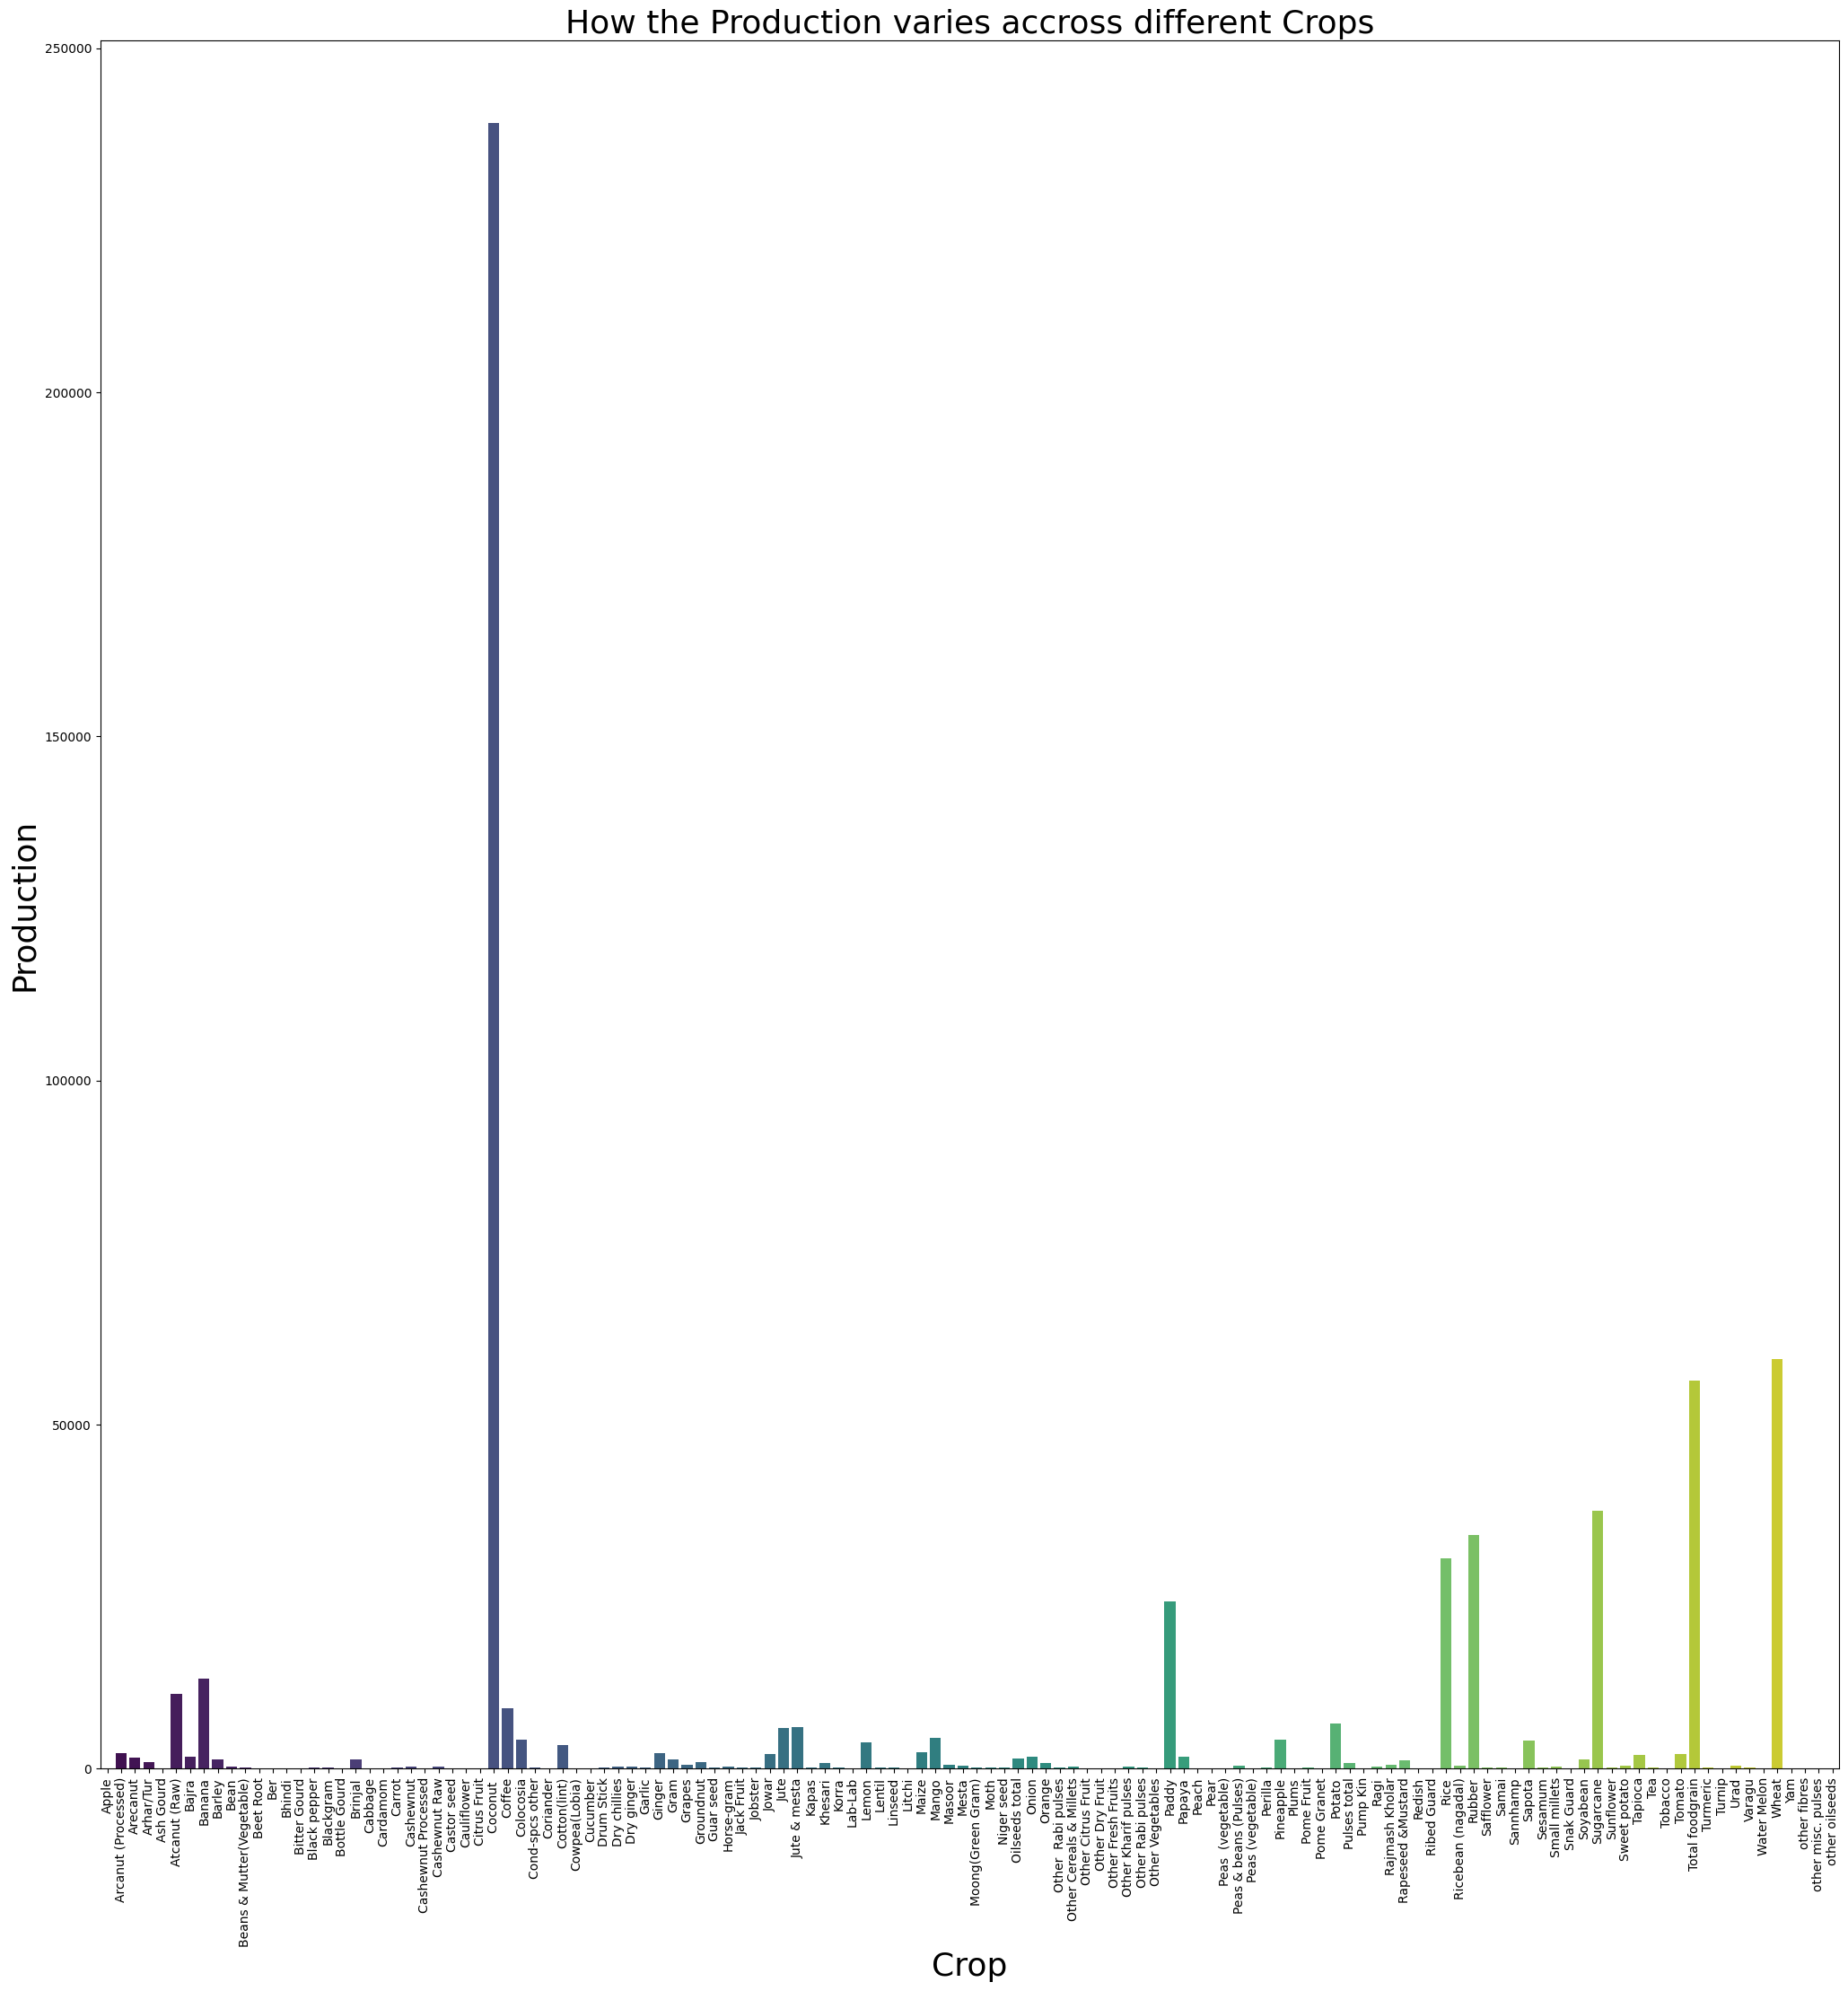

In [12]:
group_by_crop = df.groupby("Crop")["Production"].median().reset_index()

plt.figure(figsize=(25, 25))
sns.barplot(x=group_by_crop["Crop"], y=group_by_crop["Production"], palette='viridis')
plt.title("How the Production varies accross different Crops", fontsize=26)
plt.xlabel("Crop", fontsize=26)
plt.ylabel("Production", fontsize=26)
plt.xticks(rotation=90)
plt.show()

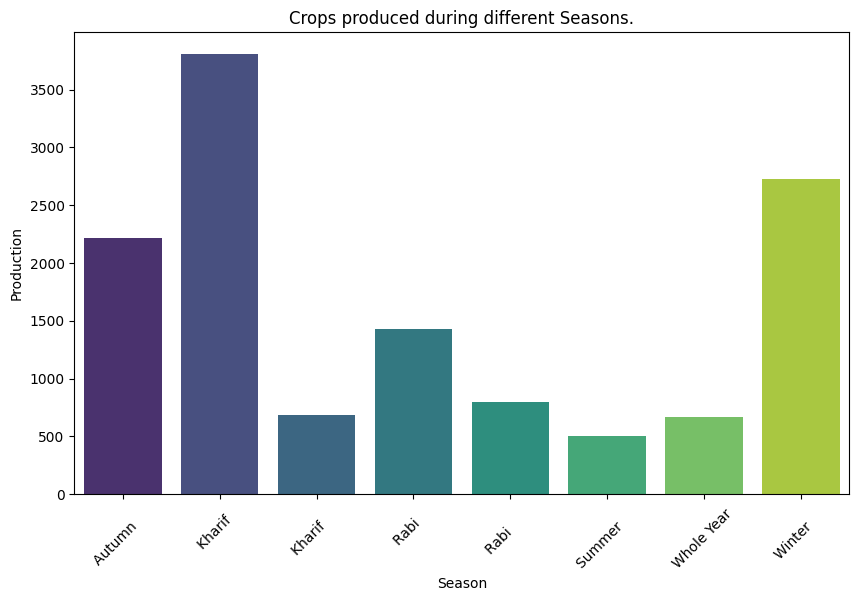

In [13]:
group_by_crop = df.groupby("Season")["Production"].median().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=group_by_crop["Season"], y=group_by_crop["Production"], palette='viridis')
plt.title("Crops produced during different Seasons.")
plt.xlabel("Season")
plt.ylabel("Production")
plt.xticks(rotation=45)
plt.show()

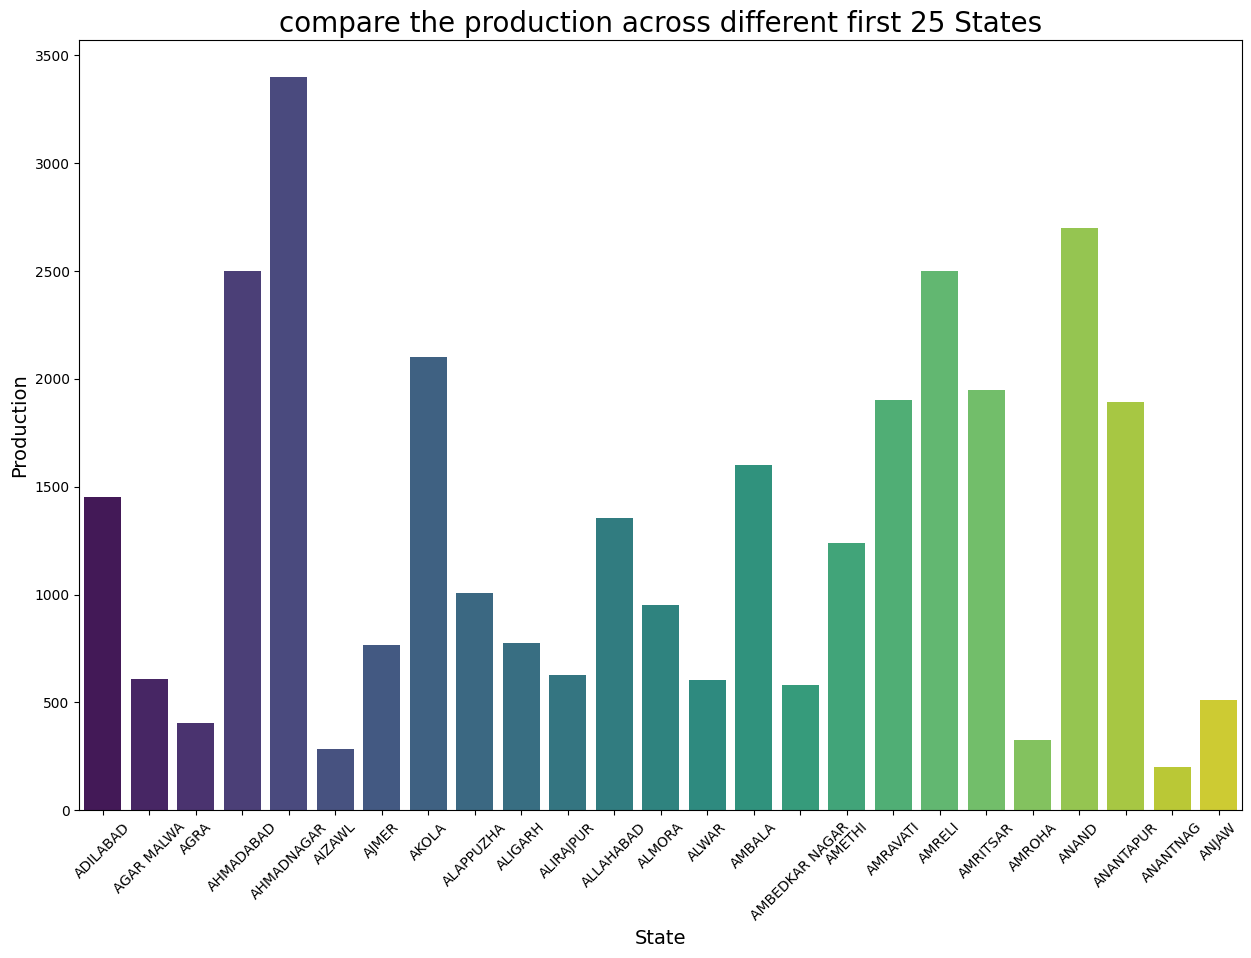

In [14]:
group_by_crop = df.groupby("District_Name")["Production"].median().reset_index().head(25)

plt.figure(figsize=(15, 10))
sns.barplot(x=group_by_crop["District_Name"], y=group_by_crop["Production"], palette='viridis')
plt.title("compare the production across different first 25 States", fontsize=20)
plt.xlabel("State",  fontsize=14)
plt.ylabel("Production",  fontsize=14)
plt.xticks(rotation=45) 
plt.show()

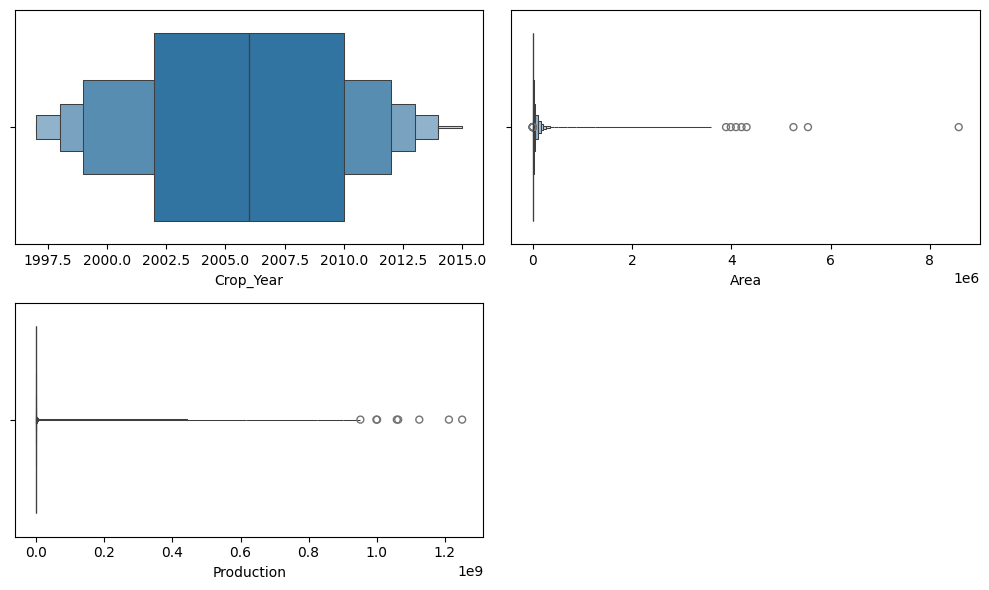

In [15]:
plt.figure(figsize=(10,6))
for i, feature in enumerate(df.select_dtypes(include="number").columns):
    plt.subplot(2, 2, i+1)
    sns.boxenplot(data=df, x=feature)
plt.tight_layout()

# Encoding

In [16]:
encoder = LabelEncoder()

df["State_Name"] = encoder.fit_transform(df["State_Name"])
df["District_Name"]= encoder.fit_transform(df["District_Name"])
df["Season"] = encoder.fit_transform(df["Season"])
df["Crop"] = encoder.fit_transform(df["Crop"])

# Correlation

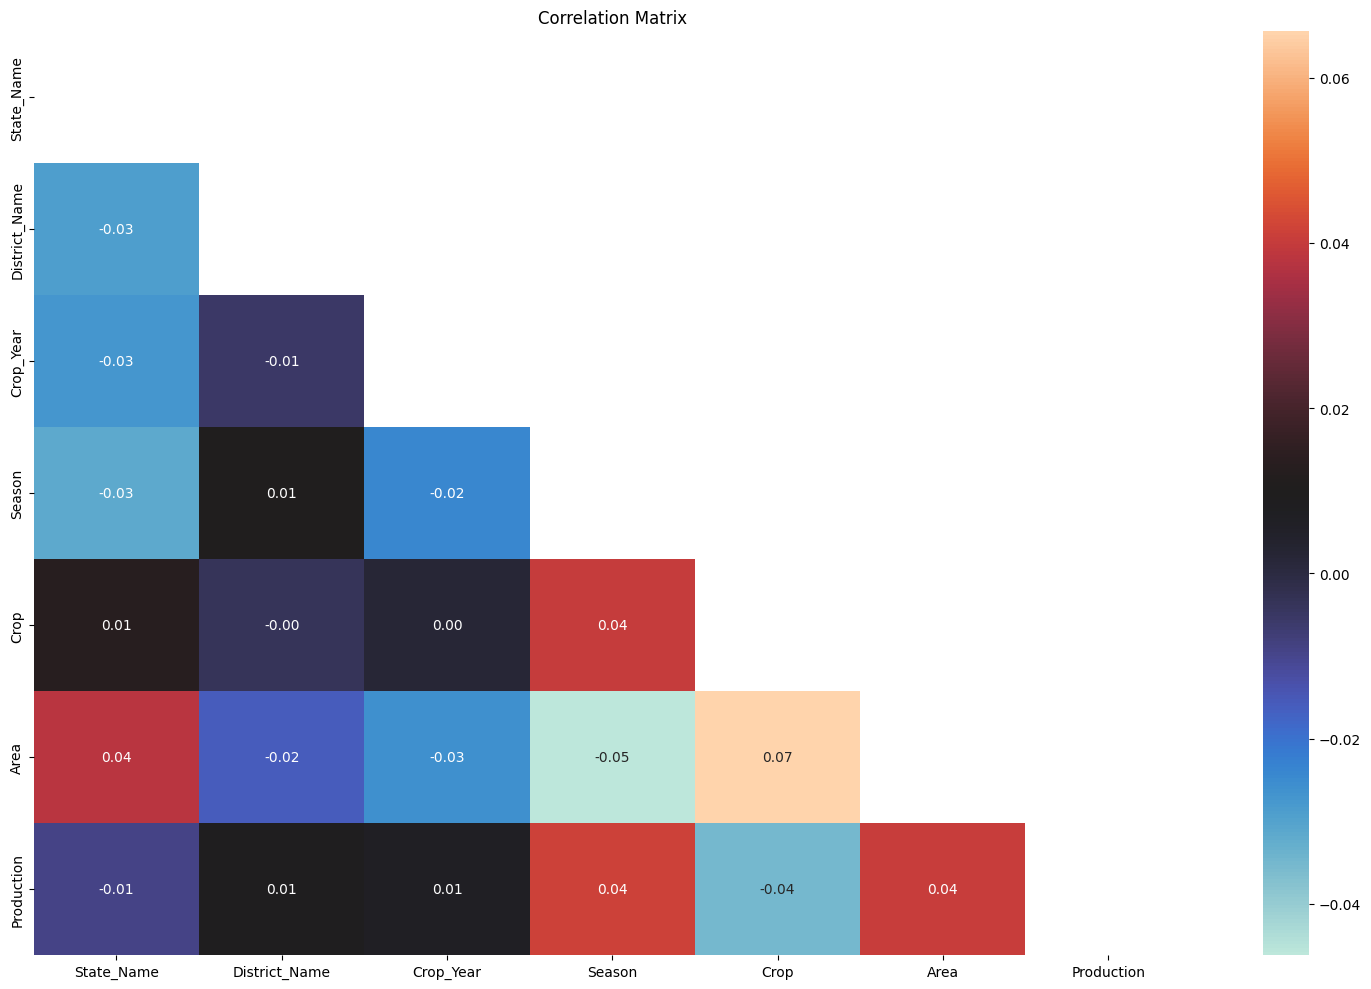

In [17]:
corr = df.corr()
mask_ut = np.triu(np.ones(corr.shape)).astype(np.bool_)

plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="icefire", mask=mask_ut)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [18]:
def distance(data, label=''):
    corr = data.corr(method ='spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

    plt.figure(figsize=(10, 8), dpi=300)
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f"Feature Distance in {label} Dataset", weight = 'bold', size=20)
    plt.show()

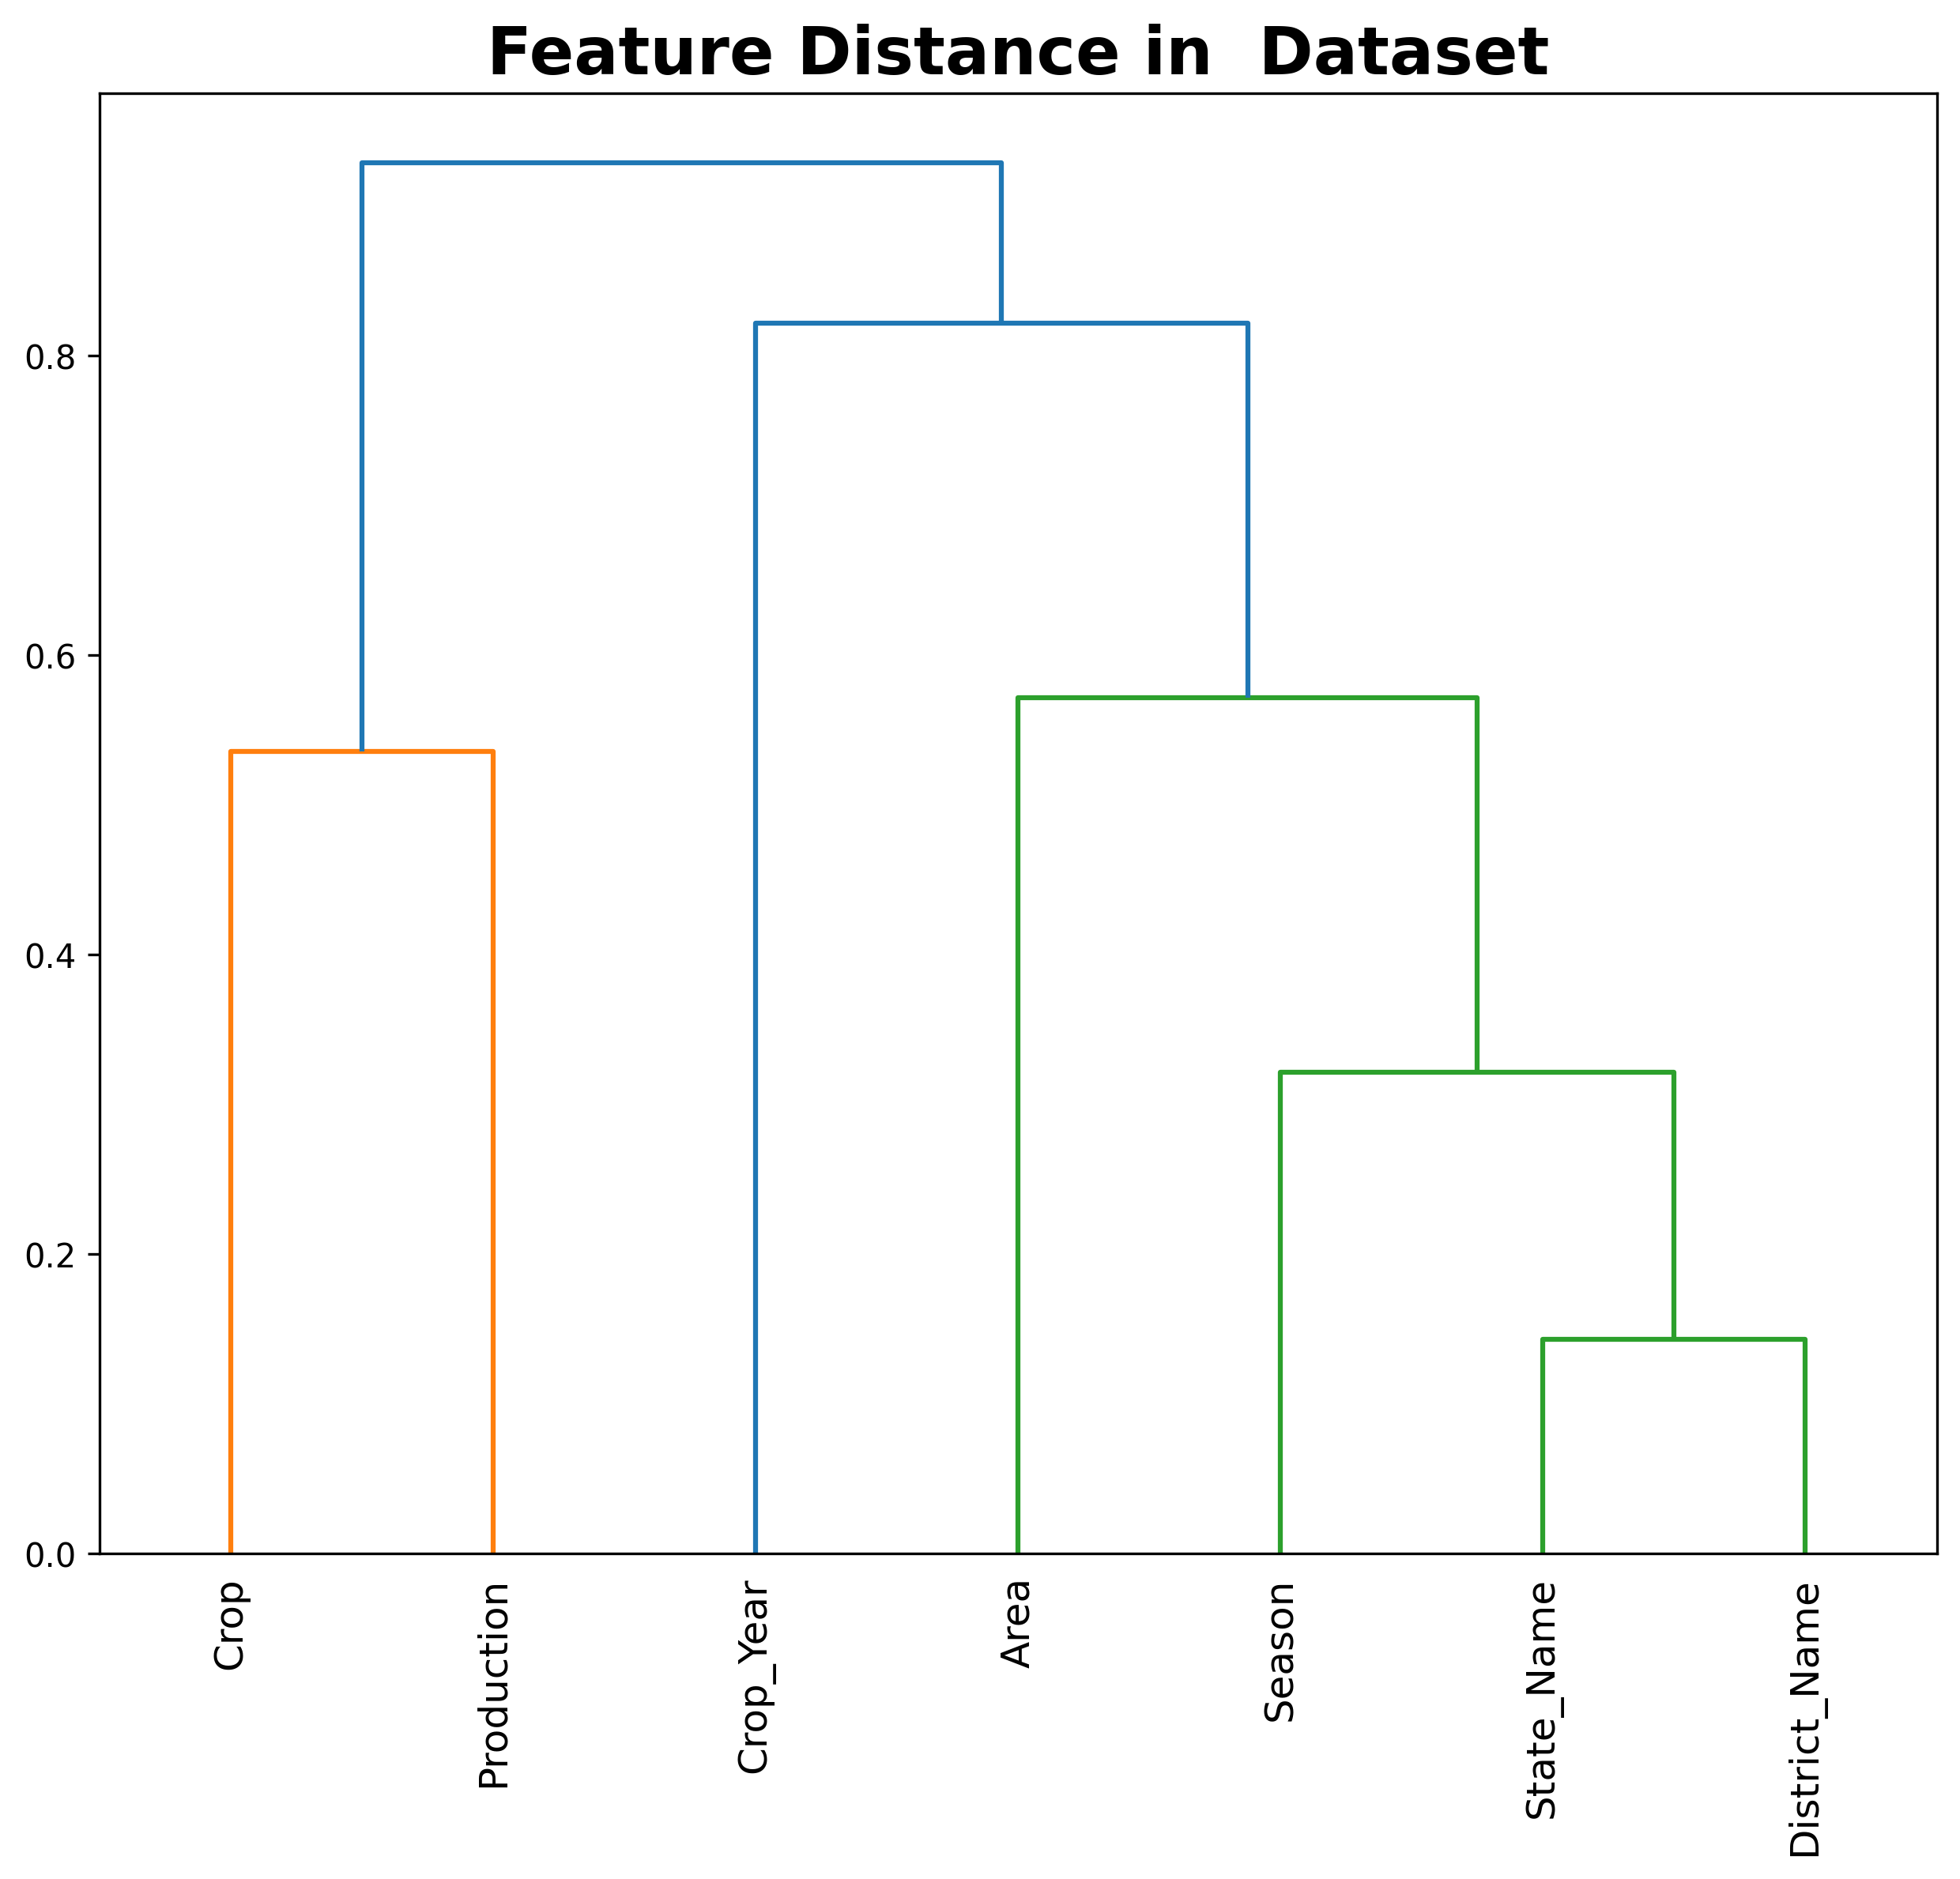

In [19]:
distance(corr)

### Missing Value Treatment

In [20]:
df.dropna(inplace=True)

### Outliears Treatment

In [21]:
q1 = df["Area"].quantile(0.25)
q3 = df["Area"].quantile(0.75)
iqr = q3 - q1

upper_limit= q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

df = df.loc[(df["Area"] > lower_limit) & (df["Area"] < upper_limit)]

## Scaling

In [22]:
X = df.drop("Production", axis=1)
y =df["Production"]

In [23]:
standard_scaler = StandardScaler()

X = standard_scaler.fit_transform(X)

In [24]:
min_max_scaler = MinMaxScaler()
y = np.array(y)
y = min_max_scaler.fit_transform(y.reshape(-1, 1))

# Train Test Split

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((161944, 6), (161944, 1), (40486, 6), (40486, 1))

# Model Building

In [26]:
param={
    'n_estimators':300,
    'learning_rate':0.1,
    'max_depth':7,
    'subsample':1.0,
    'colsample_bytree':1.0,
    'gamma':0
}

reg = XGBRegressor(random_state=42, **param)

In [27]:
reg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Evaluation

In [29]:
y_pred = reg.predict(x_test)

In [30]:
print("Mae: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("R2-score: ", f"{(r2_score(y_test, y_pred) * 100): 0.1f}","%")

Mae:  0.00011007623237860008
MSE:  5.665328374001729e-06
R2-score:   92.1 %


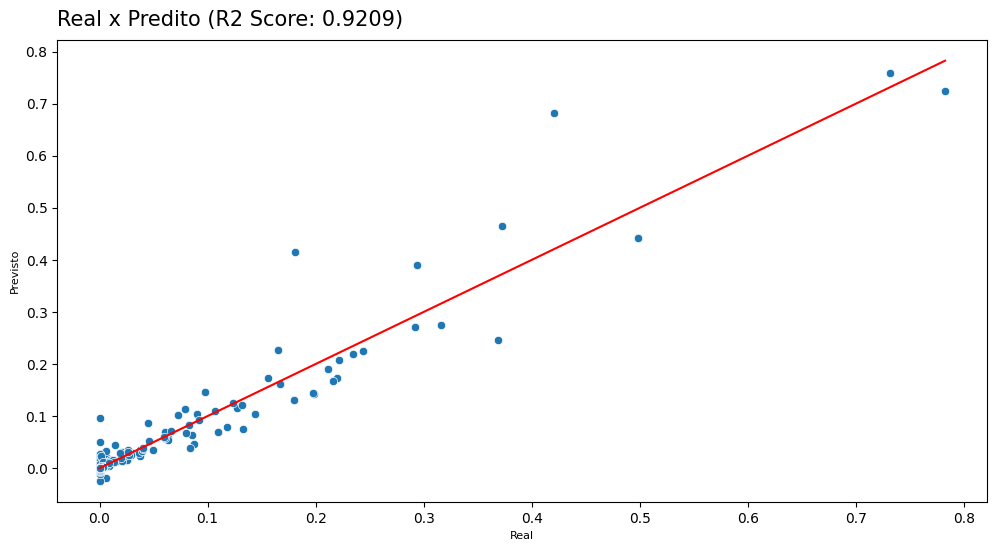

In [31]:
fig, ax = plt.subplots(figsize = (12, 6))

y_test = y_test.flatten() if hasattr(y_test, "flatten") else y_test
y_pred = y_pred.flatten() if hasattr(y_pred, "flatten") else y_pred

sns.scatterplot(x = y_test, y = y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')
ax.set_title(f"Real x Predito (R2 Score: {r2_score(y_test, y_pred):.4f})", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Real", fontsize = 8)
ax.set_ylabel("Previsto", fontsize = 8)
plt.show()